# GLM: 1st-level Analysis

The objective in this example is to model the timecourse of each voxel. This will allow us to answer question regarding to the voxel response to different stimuli. 

We will model the activation at each voxel $y$ as a weighed sum of explanatory variables $x_{i}$ 
and error term ${\epsilon}$

$${y} = {\beta}_{0} + \sum \limits _{i=1} ^{N} x_{i}{\beta}_{i} + {\epsilon} $$

or in matrix notation

$$ y = {\beta} X + {\epsilon} $$

which can be solved with Ordinary Least Squares regression.

The parameters ${\beta}$ represent the contribution of each variable to the voxel activation.

The error terms are assumed to be independent and identically distributed.

![Design matrix](https://mri-q.com/uploads/3/4/5/7/34572113/9355842_orig.jpg)

The matrix  𝑋  is also called design matrix.It is up to the researcher which factors to include in the design matrix. The design matrix contains factors that a related to the hypothesis the researcher want to answer. Furthermore, sometimes in it are also included factors that are not related to the hypothesis, but are know sources of variability (nuisance factors).

Now lets take a look how we take into account the delayed bold response.
The hemodynamic response function might look something like this:


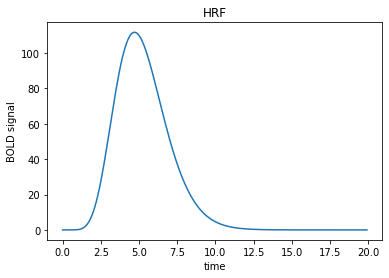

In [1]:
import numpy as np 
import matplotlib.pyplot as plt


def hrf(t):
    return t ** 8.6 * np.exp(-t / 0.547)

hrf_times = np.arange(0, 20, 0.1)
hrf_signal = hrf(hrf_times)
plt.plot(hrf_times, hrf_signal)
plt.xlabel('time')
plt.ylabel('BOLD signal')
_ = plt.title('HRF')

In the design often we want to include variables, that indicate presence or absence of a stimuli.
Let's say we had the 3 stimuli during the timecourse

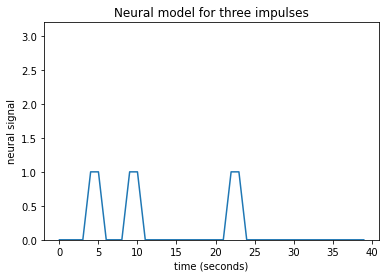

In [2]:
n_time_points = 40

times = np.arange(0, n_time_points)  

neural_signal = np.zeros(n_time_points)
neural_signal[4:6] = 1  # A 3 second event
neural_signal[9:11] = 1
neural_signal[22:24] = 1

plt.plot(times, neural_signal)
plt.xlabel('time (seconds)')
plt.ylabel('neural signal')
plt.ylim(0, 3.2)
_ = plt.title('Neural model for three impulses')

Next we have to convolve signal with our hrf function

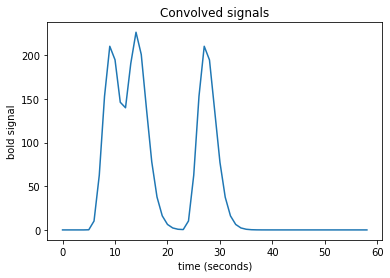

In [3]:
hrf_times = np.arange(20)
hrf_signal = hrf(hrf_times)
bold_signal = np.convolve(neural_signal, hrf_signal)

tailed_respose_times = np.arange(n_time_points + hrf_times.shape[0] - 1)
plt.plot(tailed_respose_times, bold_signal)
plt.xlabel('time (seconds)')
plt.ylabel('bold signal')
_ = plt.title('Convolved signals')

After that we can fit our fMRI data to the design Matrix and use GLM to for hypotesis testing.
We can evaluate whether a given factor $i$ has a considerable contribution by its coefficient ${\beta}_{i}$.
With t-test we can evaluate whether ${\beta}_{i}$ > 0. We can also test hypothesis of the form ${\beta}_{i}$ > ${\beta}_{j}$.

The general form of the hypothesis tests which forms a **contrast** is:
$$\sum \limits _{i=1} ^{P} c_{i}{\beta}_{i} > 0 $$

Typical values for $c$ are 1 and -1.
Typically contrasts are express as:$ [c_{1}, c_{2}, ..., c_{N}]$.

For example the contrast [1, 0] tests ${\beta}_{1}$ > 0.

This contrasts form a t-statistics (Recall that coefficient/std(coefficient) in OLS regression follow t-distribution with n-p-1 df).

We can combine several contrasts and form F-statics. In the contexts of fMRI the F-tests help us answer questions like "Is effect A or effect B or effect C, or any combination of them, significantly non-zero?".

Recall that F test is used for comparison between reduced model RF and full model FM:
$$ F = \frac{(SSE(RM)-SSR(FM)) /(p+1-k))}{SSE(FM)/(n-p-1)} $$

where the reduced model have k distinct parameters


Combining the test results from all voxels we get statistical map of brain activity.
Now that the theory out of our way we can see how it is done in Nipype.


# 1st Leval Analysis in Nipype

 We will use the preprocessed files we got and run 1st-level analysis (individual analysis) for each subject. We will perform the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In [4]:
import pandas as pd
import os

from nilearn import plotting
%matplotlib inline


from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from utils import list_files

200918-09:07:47,265 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [5]:
# specify paths
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
# Repetition time(TR) of functional images
TR = 2.5

## Prepare design matrix
Let's take a look how the stimuli onset and duration look like.This information is store in a ``tsv`` file. This file will help us build the design matrix.

The three different conditions in the **fingerfootlips** task are:
- **finger**
- **foot**
- **lips**

In [6]:
trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo.head()

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot


In [7]:
def subjectinfo(subject_id):
    import pandas as pd
    from nipype.interfaces.base import Bunch

    
    trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Initiate Nodes

In [8]:
# SpecifyModel - Generates SPM-specific Model
#Setup
#https://nipype.readthedocs.io/en/latest/api/generated/nipype.algorithms.modelgen.html#specifymodel
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=59
#hrf- Name of basis function(canonical)
#'derivs': [1, 0]-Time derivatives : Time and Dispersion

#model_serial_correlations-serial correlations using an autoregressive estimator (order 1)

level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
#https://www.fil.ion.ucl.ac.uk/spm/doc/manual.pdf#page=69

level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

## Specify contrasts
We are gona perform several T tests and one F test. Recall the general form of the hypothesis are

$$\sum \limits _{i=1} ^{N} c_{i}{\beta}_{i} > 0 $$

In [9]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
# contrast =  [<contrast_name>, <test>, <condition_names>, <[c1, c2, c3]>]
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont06 = ['activation',     'F', [cont02, cont03, cont04]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06]

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [10]:
#Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {
        'func': 'datasink/preproc/sub-{subject_id}/task-{task_id}/fwhm-5_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii',
        'mc_param': 'datasink/preproc/sub-{subject_id}/task-{task_id}/sub-{subject_id}_ses-test_task-{task_id}_bold.par',
        'outliers': 'datasink/preproc/sub-{subject_id}/task-{task_id}/art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt'
    }
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and **connect** the interface nodes and the I/O stream to each other.

In [11]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = f'{experiment_dir}/{working_dir}'

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

## Visualize the workflow

200918-09:07:47,884 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


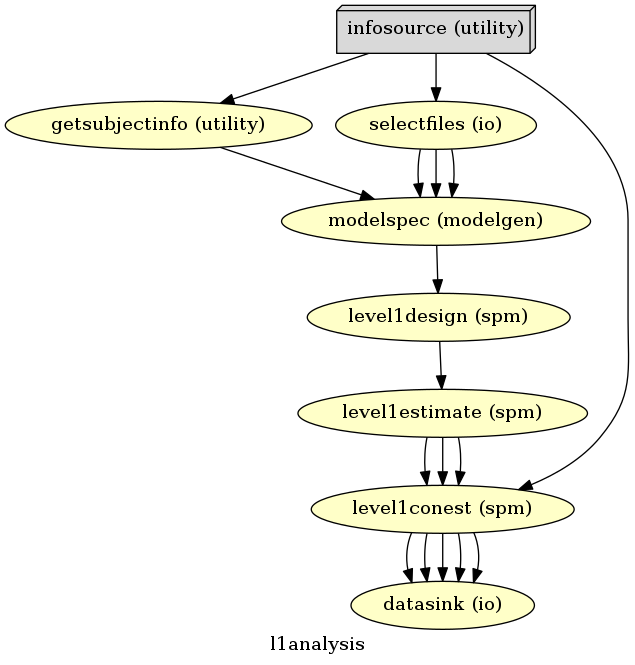

In [12]:
# Save the 1st-level analysis graph as png
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph.png')

200918-09:07:48,425 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=flat, simple_form=True).


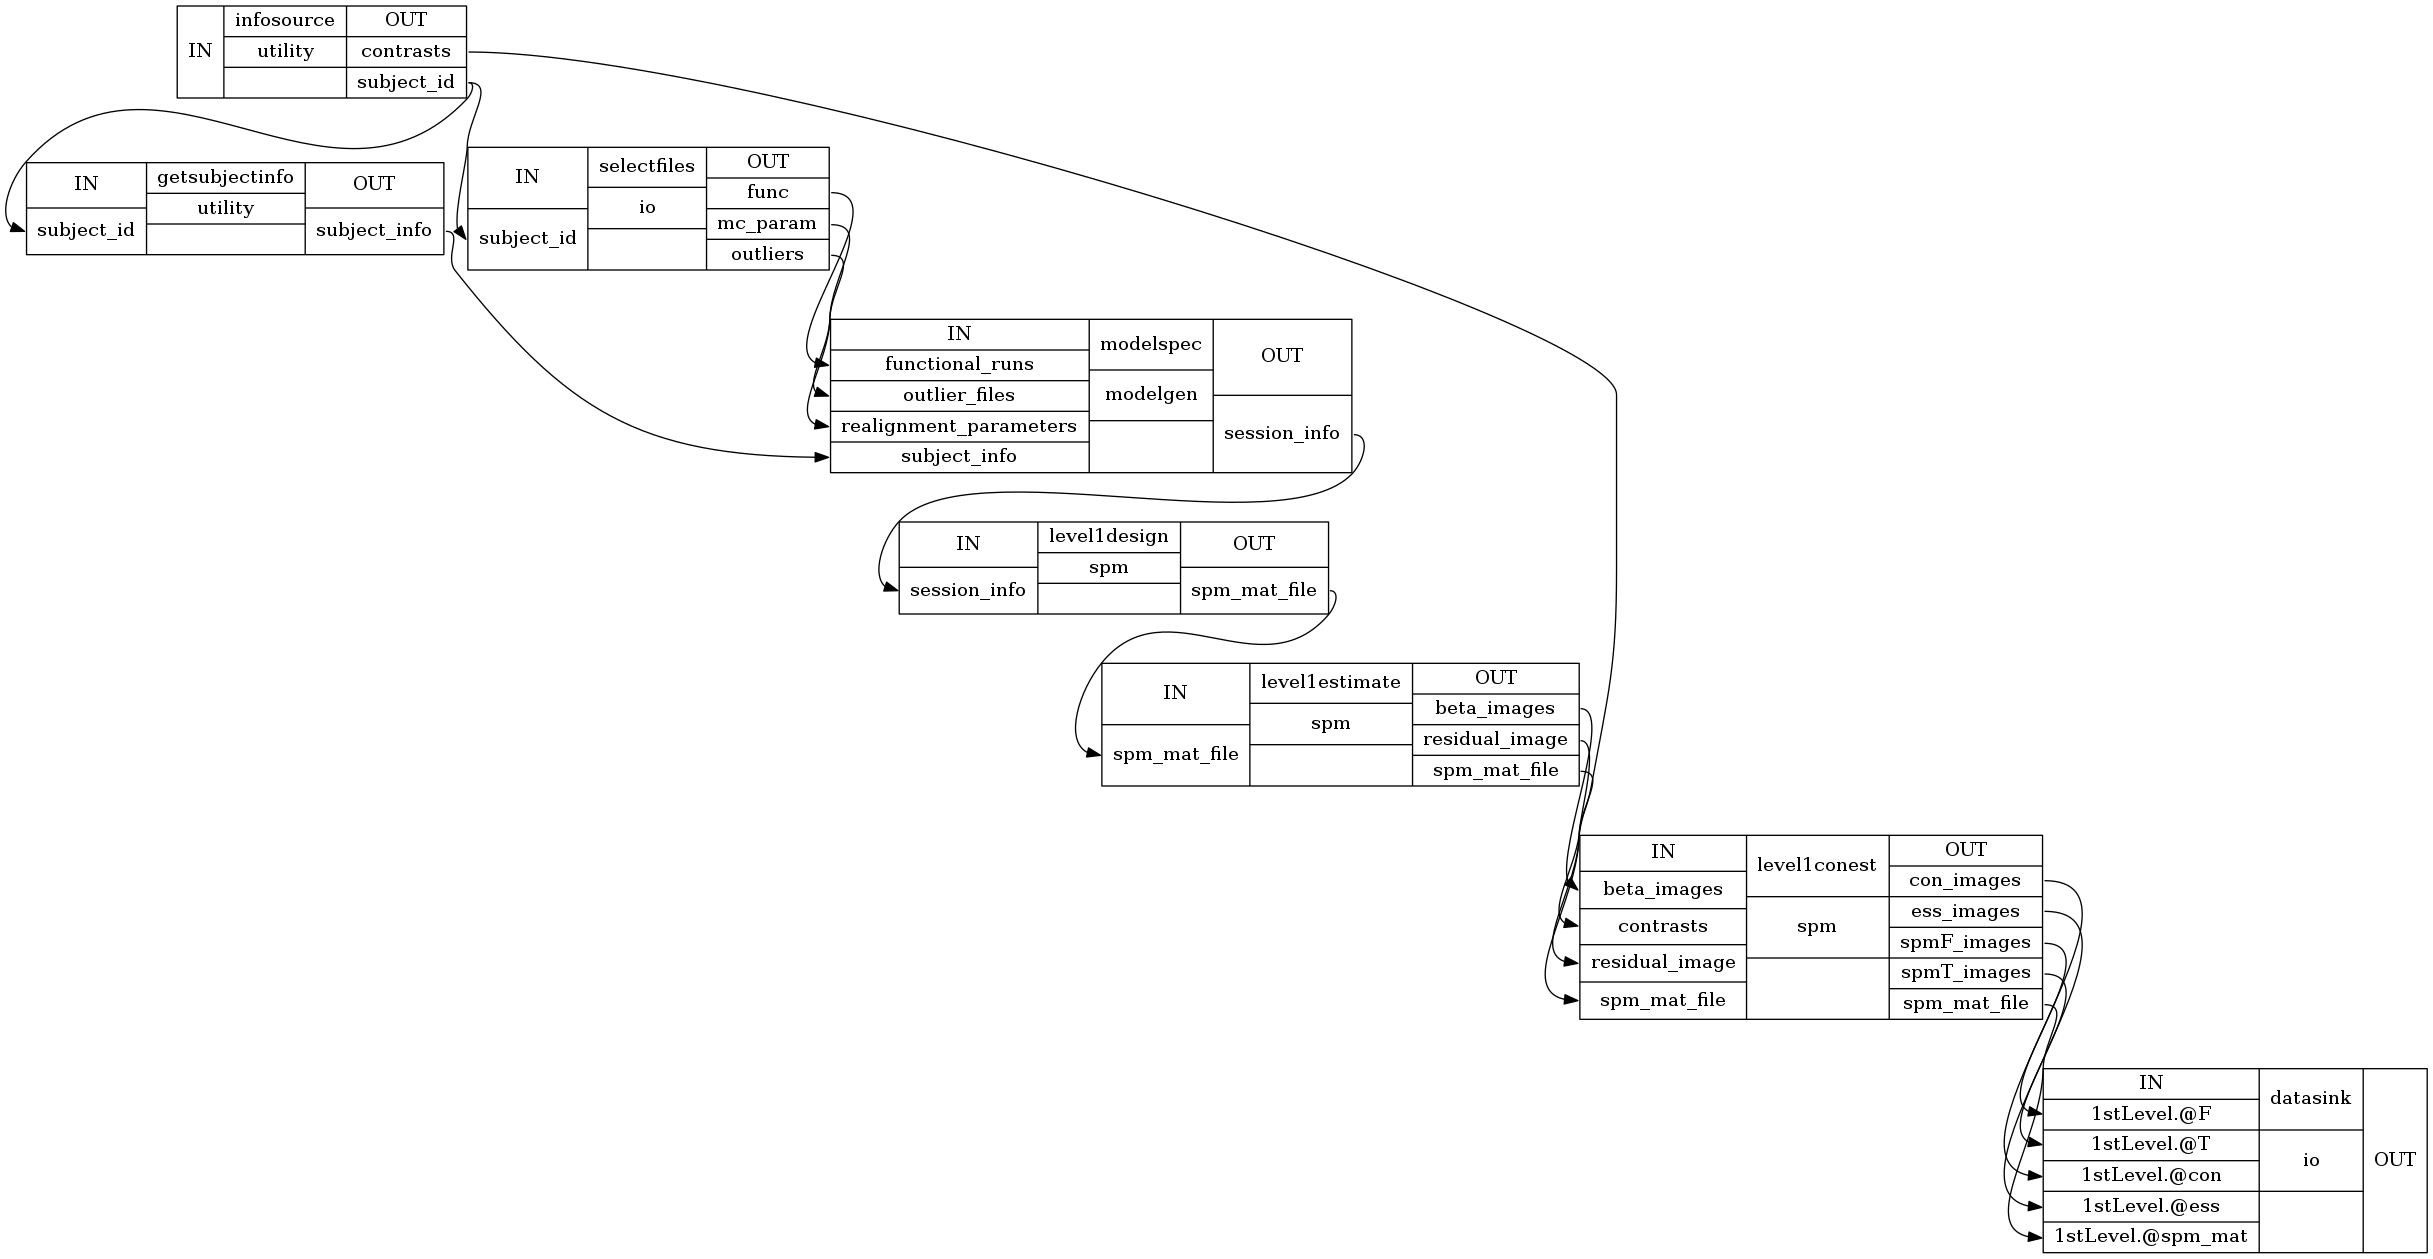

In [13]:
# show detailed workflow
l1analysis.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=f'{l1analysis.base_dir}/l1analysis/graph_detailed.png')

##  Run the Workflow

Run the 1st-level analysis workflow.

In [14]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

200918-09:07:48,470 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
200918-09:07:48,530 nipype.workflow INFO:
	 Running in parallel.
200918-09:07:48,536 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 226.64/226.64, Free processors: 4/4.
200918-09:07:48,620 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_10/selectfiles".200918-09:07:48,620 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_subject_id_09/getsubjectinfo".

200918-09:07:48,631 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")200918-09:07:48,631 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

200918-09:07:48,639 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".200918-09:07:48,621 nipype.workflow INFO:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_08/modelspec/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200918-09:07:52,652 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
200918-09:07:52,667 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200918-09:07:52,680 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
200918-09:07:52,686 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
200918-09:07:54,542 nipype.workflow INFO:
	 [Job 16] Completed (l1analysis.modelspec).
200918-09:07:54,545 nipype.workflow INFO:
	 [Job 21] Completed (l1analysis.getsubjectinfo).
200918-09:07:54,550 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 14 jobs ready. Free memory (GB): 226.24/226.64, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
200918-09:07:54,613 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_su

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_07/modelspec/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200918-09:07:56,647 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
200918-09:07:58,546 nipype.workflow INFO:
	 [Job 23] Completed (l1analysis.modelspec).
200918-09:07:58,550 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 226.04/226.64, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
200918-09:07:58,615 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_07/level1design".
200918-09:07:58,661 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
200918-09:08:00,549 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 12 jobs ready. Free memory (GB): 225.84/226.64, Free processors: 0/4.
                     Currently running:
                       * l1analysis.l

200918-09:08:27,981 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
200918-09:08:28,199 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
200918-09:08:28,575 nipype.workflow INFO:
	 [Job 5] Completed (l1analysis.level1conest).
200918-09:08:28,578 nipype.workflow INFO:
	 [Job 12] Completed (l1analysis.level1conest).
200918-09:08:28,582 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 14 jobs ready. Free memory (GB): 226.24/226.64, Free processors: 2/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1conest
200918-09:08:28,646 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_10/datasink".200918-09:08:28,646 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.datasink" in "/output/workingdir/l1analysis/_subject_id_09/datasink".

200918-09:08:28,660 nipype.workflow INFO:
	 [Node] Running "datasink" ("ni

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:491: UserWarning: loadtxt: Empty input file: "/output/workingdir/l1analysis/_subject_id_06/modelspec/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


200918-09:08:32,675 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".200918-09:08:32,675 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmT_0002.nii -> /output/datasink/1stLevel/sub-08/spmT_0002.nii

200918-09:08:32,677 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmT_0003.nii -> /output/datasink/1stLevel/sub-08/spmT_0003.nii
200918-09:08:32,679 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmT_0004.nii -> /output/datasink/1stLevel/sub-08/spmT_0004.nii
200918-09:08:32,681 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmT_0005.nii -> /output/datasink/1stLevel/sub-08/spmT_0005.nii
200918-09:08:32,683 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/spmF_0006.nii -> /output/datasink/1stLevel/sub-08/spmF_0006.nii
200918-09:08:32,685 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_08/con_0001.nii -> /output/datasink/1stLevel/sub

200918-09:08:38,592 nipype.workflow INFO:
	 [Job 49] Completed (l1analysis.getsubjectinfo).
200918-09:08:38,596 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 226.44/226.64, Free processors: 3/4.
                     Currently running:
                       * l1analysis.level1design
200918-09:08:38,664 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/output/workingdir/l1analysis/_subject_id_05/level1design".200918-09:08:38,665 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_subject_id_03/selectfiles".200918-09:08:38,665 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.modelspec" in "/output/workingdir/l1analysis/_subject_id_04/modelspec".


200918-09:08:38,671 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
200918-09:08:38,676 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
200918-09:08:38,681 nipype.wo

	 [Node] Finished "l1analysis.level1estimate".
200918-09:09:02,610 nipype.workflow INFO:
	 [Job 39] Completed (l1analysis.level1estimate).
200918-09:09:02,616 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 226.04/226.64, Free processors: 1/4.
                     Currently running:
                       * l1analysis.level1conest
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
200918-09:09:02,687 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1conest" in "/output/workingdir/l1analysis/_subject_id_05/level1conest".
200918-09:09:02,710 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
200918-09:09:03,570 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1estimate".
200918-09:09:04,612 nipype.workflow INFO:
	 [Job 46] Completed (l1analysis.level1estimate).
200918-09:09:04,617 nipype.workflow INFO:
	 [MultiProc] Running 3 ta

	 sub: /output/datasink/1stLevel/_subject_id_05/spmT_0005.nii -> /output/datasink/1stLevel/sub-05/spmT_0005.nii
200918-09:09:12,714 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/spmF_0006.nii -> /output/datasink/1stLevel/sub-05/spmF_0006.nii
200918-09:09:12,716 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/con_0001.nii -> /output/datasink/1stLevel/sub-05/con_0001.nii
200918-09:09:12,718 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/con_0002.nii -> /output/datasink/1stLevel/sub-05/con_0002.nii
200918-09:09:12,720 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/con_0003.nii -> /output/datasink/1stLevel/sub-05/con_0003.nii
200918-09:09:12,722 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/con_0004.nii -> /output/datasink/1stLevel/sub-05/con_0004.nii
200918-09:09:12,724 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_05/con_0005.nii -> /output/datasi

	 sub: /output/datasink/1stLevel/_subject_id_02/spmT_0004.nii -> /output/datasink/1stLevel/sub-02/spmT_0004.nii
200918-09:09:50,748 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/spmT_0005.nii -> /output/datasink/1stLevel/sub-02/spmT_0005.nii
200918-09:09:50,750 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/spmF_0006.nii -> /output/datasink/1stLevel/sub-02/spmF_0006.nii
200918-09:09:50,752 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/con_0001.nii -> /output/datasink/1stLevel/sub-02/con_0001.nii
200918-09:09:50,754 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/con_0002.nii -> /output/datasink/1stLevel/sub-02/con_0002.nii
200918-09:09:50,756 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/con_0003.nii -> /output/datasink/1stLevel/sub-02/con_0003.nii
200918-09:09:50,758 nipype.interface INFO:
	 sub: /output/datasink/1stLevel/_subject_id_02/con_0004.nii -> /output/data

In [15]:
#Crashs information is stored in .pklz files
# In case of a crash use the following command
#!nipypecli crash <Last generated .pklz file>

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should one image for each subject and contrast (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for F-contrasts)

In [16]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
├── sub-01
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-02
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-03
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│   ├── ess_0006.nii
│   ├── spmF_0006.nii
│   ├── SPM.mat
│   ├── spmT_0001.nii
│   ├── spmT_0002.nii
│   ├── spmT_0003.nii
│   ├── spmT_0004.nii
│   └── spmT_0005.nii
├── sub-04
│   ├── con_0001.nii
│   ├── con_0002.nii
│   ├── con_0003.nii
│   ├── con_0004.nii
│   ├── con_0005.nii
│  

## Visualize results

Let's look at the contrasts of one subject that we've just computed. 

In [17]:
from nilearn.plotting import plot_stat_map

#Reminder the tests were 
test_to_number = {
    1: 'average',
    2: 'Finger',
    3: 'Foot',
    4: 'Lips',
    5: 'Foot > others',
    6: 'activation'
    }
subject_id = '01'
anatimg = f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_preproc.nii.gz'

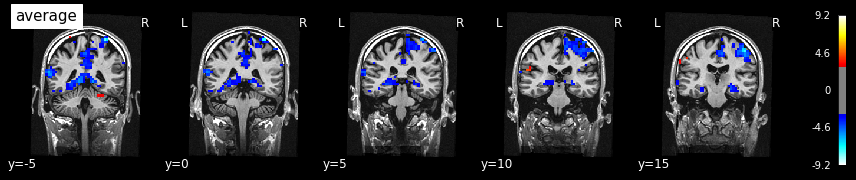

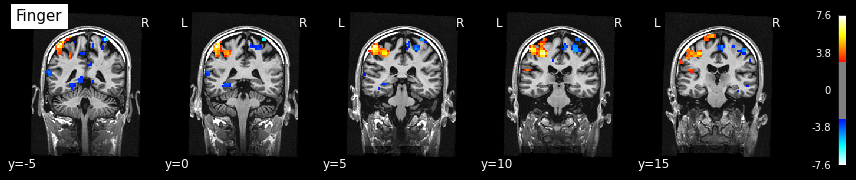

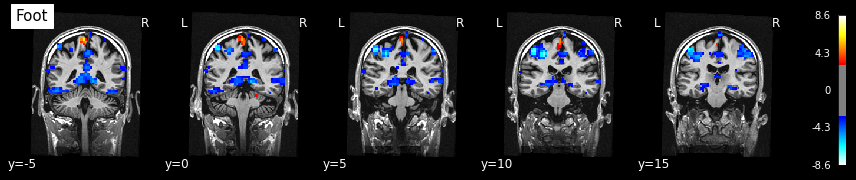

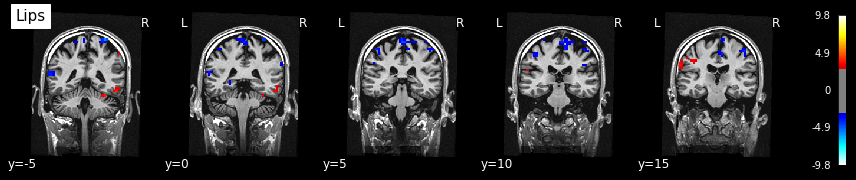

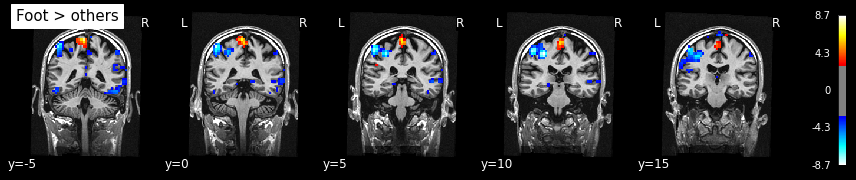

In [18]:
subject_id = '05'
 
anatimg = f'/data/ds000114/derivatives/fmriprep/sub-{subject_id}/anat/sub-{subject_id}_t1w_preproc.nii.gz'
for contrast_id in range(1, 6):
    plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmT_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

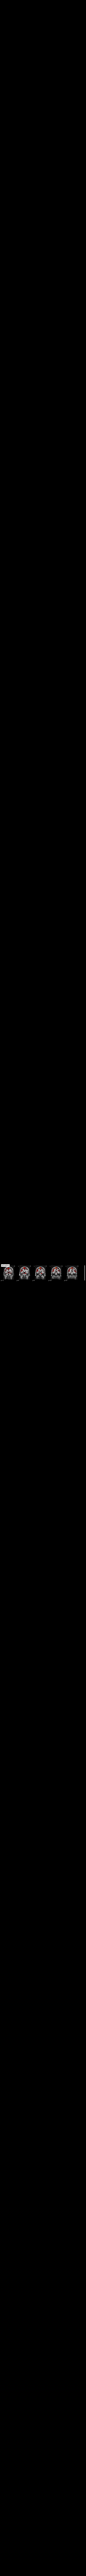

In [19]:
contrast_id = 6
subject_id = '09'

plot_stat_map(
        f'/output/datasink/1stLevel/sub-{subject_id}/spmF_000{contrast_id}.nii', title=test_to_number[contrast_id],
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

**Sources:**


[General Linear Model for Neuroimaging](https://www.fmrib.ox.ac.uk/primers/appendices/glm.pdf)

[Convolution](https://practical-neuroimaging.github.io/on_convolution.html)

[General Linear Model (GLM)](http://mriquestions.com/general-linear-model.html)


**Special thanks to Michael Notter for the wonderful [nipype tutorial](https://miykael.github.io/nipype_tutorial/)**